In [1]:
import numpy as np
import os
import cv2
import math
import pickle
from fr_utils import *
from inception_blocks import *
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import genfromtxt
from keras import backend as K
K.set_image_data_format('channels_first')
from keras.models import Model,Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense


Using TensorFlow backend.


In [2]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
       
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    ### END CODE HERE ###
    
    return loss


In [3]:

FRmodel = faceRecoModel(input_shape=(3, 96, 96))
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

pickle.dump(FRmodel,open("FRmodel.p","wb"))

  

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
def img_to_encoding(image_path, model):

    input_dim=350 # Ridge image input dimensions are (350,350). Only taking the height and width. Actually it is (350,350,3)including RGB.
    facenet_dim=96 # FaceNet model uses an input of (96,96). To take advantage of preset weights, converts Ridge images to multiple FaceNet size images

    no_of_cut=math.ceil(input_dim/facenet_dim)

    img = cv2.imread(image_path, 1)

    img=np.pad(img,((1,1),(1,1),(0,0)),'constant') # Padding so that the image dimension is divisible by the no_of cut

    mod_input_dim = img.shape[0]

    cut_dim=int(mod_input_dim/no_of_cut) # This is the dimension of the image that is cut. To make it equal to 96, padding with zeros are done.
    crop_pad=int((facenet_dim-cut_dim)/2 )# Padding equal number of zeros on both sides(up-down,left-right) to make the cut dim (88) equal to facenet dim(96)
    cropped_images=[]

    for y in range(no_of_cut):
        for x in range(no_of_cut):
            x_start=x*cut_dim
            x_end=(x+1)*cut_dim
            y_start=y*cut_dim
            y_end=(y+1)*cut_dim
            img_part=img[x_start:x_end,y_start:y_end,:]
            img_part=np.pad(img_part,((crop_pad,crop_pad),(crop_pad,crop_pad),(0,0)),'constant')
            cropped_images.append(img_part)

    embeddings=None
    for imag in cropped_images:
        img = imag[...,::-1]
        img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
        x_train = np.array([img])
        embedding = model.predict_on_batch(x_train)
        if embeddings is None:
            embeddings=embedding
        else:
            embeddings=np.concatenate((embeddings,embedding),axis=1)
        flat_input=embedding.flatten()
    
    return embeddings

In [5]:
 def show_images(image_path_original,image_path_check):
    
    imageA=mpimg.imread(image_path_original)
    imageB=mpimg.imread(image_path_check)
    fig = plt.figure("Comparison")
 
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the images
    plt.show()

In [6]:
def verify(image_path_original, image_path_check, model): 
    
    encoding_original = img_to_encoding(image_path_original,model)
    encoding_check = img_to_encoding(image_path_check,model)
    
    dist = np.linalg.norm(encoding_original-encoding_check)
 #   dist = dist/256
    # setup the figure
    
    show_images(image_path_original,image_path_check)
    print ("Distance is " , dist)
    if dist < .5:
        print("It's similar")          
    else:
        print("It's not similar")
    

In [7]:

def verify_ml_approach(image_path_original,image_path_check):
    verify(image_path_original, image_path_check, FRmodel)
    
  

In [8]:
def load_train_data():
    print("In load train data")
    dataset = np.genfromtxt("data_from_prg.txt", dtype="U" ,delimiter="," )
    X = dataset[:,0:2]
    Y = dataset[:,2]
    Y= [int(i) for i in Y]
    m=len(Y)
    return X,Y,m


In [9]:
def getimagePath(name):
    return('images/'+str(name)+'.png')

In [10]:
def getSimpleModel():
    print("In get Simple Model")
    inputs=Input(shape=(4096,))
    # a layer instance is callable on a tensor, and returns a tensor
    x = Dense(1024, activation='relu')(inputs)
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(11, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)
    return model

In [11]:
def getSeqModel():
    model = Sequential()
    model.add(Dense(64, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    return model

In [12]:
def prepare_train_data(X,Y,m,classes=11):
    print("In prepare train data")
    dat=np.zeros((1,4096))
    data=np.zeros((m,4096))
    labels=np.zeros((m,classes))
    row=0
    count=0
    for [ori,chk] in X:
        print(count)
        count=count+1
        ori_encoding=img_to_encoding(ori, FRmodel)
        chk_encoding=img_to_encoding(chk, FRmodel)
        dat=np.concatenate((ori_encoding,chk_encoding),axis=1)
        data[row,:]=dat
        labels[row,Y[row]]=1
        row=row+1  
    return data,labels

In [20]:
def load_prepare_data():
    X,Y,m=load_train_data()
    data,labels=prepare_train_data(X,Y,m)
    data_and_labels={"data":data,"labels":labels}
    pickle.dump(data_and_labels, open( "data_labels.p", "wb" ) )

In [21]:
load_prepare_data()

In load train data
In prepare train data
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
2

In [22]:
def train_2nd_model():
    datalabels = pickle.load( open( "data_labels.p", "rb" ) )
    data=datalabels.get("data")
    labels=datalabels.get("labels")
    
    Smodel=getSimpleModel()
    Smodel.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    Smodel.fit(data,labels,epochs=50 )  # starts training
    return Smodel
    

In [14]:
a=img_to_encoding("modified_images\Image1_0_1217.png", FRmodel)
print(a)
print("Done")

[[ 0.13665481 -0.00372616 -0.05390335 ... -0.02503781  0.03015647
  -0.08161039]]
Done


In [23]:
Smodel=train_2nd_model()

In get Simple Model
Epoch 1/50
591/591 [==============================] - 3s 4ms/step - loss: 2.3936 - acc: 0.2047
Epoch 2/50
591/591 [==============================] - 1s 2ms/step - loss: 2.1230 - acc: 0.2386
Epoch 3/50
591/591 [==============================] - 1s 2ms/step - loss: 2.1126 - acc: 0.2453
Epoch 4/50
591/591 [==============================] - 1s 2ms/step - loss: 2.1183 - acc: 0.2335
Epoch 5/50
591/591 [==============================] - 2s 3ms/step - loss: 2.1005 - acc: 0.2403
Epoch 6/50
591/591 [==============================] - 1s 2ms/step - loss: 2.0984 - acc: 0.2420
Epoch 7/50
591/591 [==============================] - 1s 2ms/step - loss: 2.0904 - acc: 0.2437
Epoch 8/50
591/591 [==============================] - 1s 2ms/step - loss: 2.0918 - acc: 0.2369
Epoch 9/50
591/591 [==============================] - 1s 2ms/step - loss: 2.0950 - acc: 0.2403
Epoch 10/50
591/591 [==============================] - 1s 2ms/step - loss: 2.0900 - acc: 0.2487
Epoch 11/50
591/591 [========

In [24]:
 def predict(image_path_original,image_path_check,FRmodel,Smodel):
    encoding_original = img_to_encoding(image_path_original,FRmodel)
    encoding_check = img_to_encoding(image_path_check,FRmodel)
    dat=np.concatenate((encoding_original,encoding_check),axis=1)
    
    prediction = Smodel.predict_on_batch(dat)
    return prediction

In [25]:
def predict_2_models(image_path_original,image_path_check):
    show_images(image_path_original,image_path_check)
    print("Scoring...............................")
    prediction = predict(image_path_original, image_path_check, FRmodel,Smodel)
    score = np.argmax(prediction)
    print("Score of similarity is ", score)

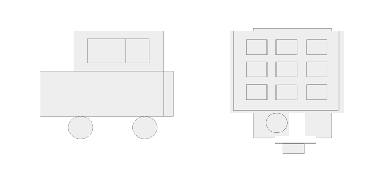

Distance is  0.49753287
It's similar


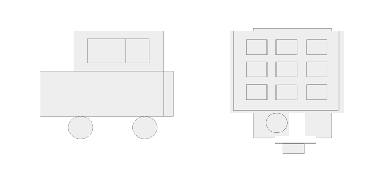

Scoring...............................
Score of similarity is  10


In [26]:
verify_ml_approach("images/image2.png", "images/image1_modified.png")
predict_2_models("images/image2.png", "images/image1_modified.png")

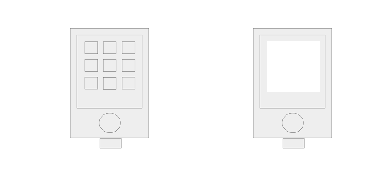

Distance is  0.32661512
It's similar


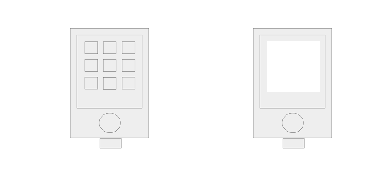

Scoring...............................
Score of similarity is  10


In [27]:
verify_ml_approach("images/image1.png", "images/image1_modified1.png")
predict_2_models("images/image1.png", "images/image1_modified1.png")

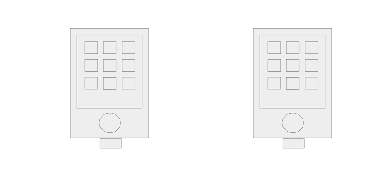

Distance is  0.0
It's similar


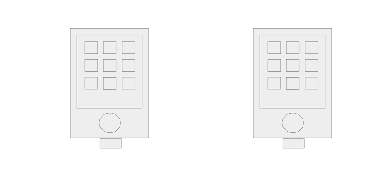

Scoring...............................
Score of similarity is  10


In [32]:
verify_ml_approach("ridge_images/Images/Image1.png", "ridge_images/Images/Image1.png")
predict_2_models("ridge_images/Images/Image1.png", "ridge_images/Images/Image1.png")

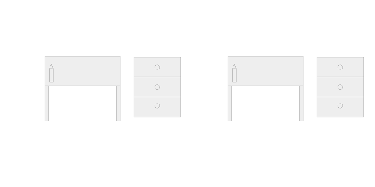

Distance is  0.0
It's similar


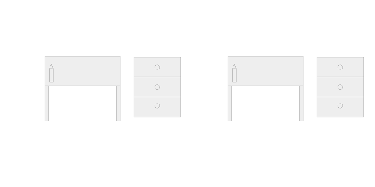

Scoring...............................
Score of similarity is  10


In [28]:
verify_ml_approach("images/image3.png", "images/image3.png")
predict_2_models("images/image3.png", "images/image3.png")